## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

To not forget anything later, let us globaly define the number of events in the MG sample

In [2]:
lhedatafile = 'data/madminer_lhedata.h5'
detectordatafile = 'data/madminer_detectordata.h5'
nsamples = 100000

## T3 Optimization: ML settings

The setup of the MLForge includes a set of input parameters. So far we have just used the default setup. Now we will see how changing this setup effects the performance of the Machine Learning the the accuracy of the score estimation. 

### T3a) Run the Data Augmentation and Machine Learning part

First, we once again augment the dataand machine learning part again. First at truth level

In [3]:
sa = SampleAugmenter(lhedatafile, debug=False)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='train'
)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan/',
    filename='test',
    switch_train_test_events=True
)

23:44  
23:44  ------------------------------------------------------------
23:44  |                                                          |
23:44  |  MadMiner v0.1.0                                         |
23:44  |                                                          |
23:44  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
23:44  |                                                          |
23:44  ------------------------------------------------------------
23:44  
23:44  Loading data from data/madminer_lhedata.h5
23:44  Found 2 parameters:
23:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
23:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
23:44  Found 6 benchmarks:
23:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
23:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
23:44     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
23:44     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
23

and then for detector level

In [4]:
sa_det = SampleAugmenter(detectordatafile, debug=False)

x_det, theta_det, t_xz_det = sa_det.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan_det/',
    filename='train'
)

x_det, theta_det, t_xz_det = sa_det.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scan_det/',
    filename='test',
    switch_train_test_events=True
)

23:44  Loading data from data/madminer_detectordata.h5
23:44  Found 2 parameters:
23:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
23:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
23:44  Found 6 benchmarks:
23:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
23:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
23:44     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
23:44     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
23:44     morphing_basis_vector_4: CWL2 = -3.51e+01, CPWL2 = 32.41
23:44     morphing_basis_vector_5: CWL2 = 5.86, CPWL2 = 39.09
23:44  Found 21 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_a, e_l, e_a, pt_l, pt_v, pt_a, eta_l, eta_a, dphi_lv, dphi_la, dphi_va, m_la, mt, phi_resurrection
23:44  Found 77511 events
23:44  Found morphing setup with 6 components
23:44  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchma

### 8b) Define set of settings

In the following, let us define a set of setting. Later we will choose random combinations of these setting options, train the MLForge, evaulate the Fisher Information and compare the results. In particular, we consider the following settings:
- number of epochs
- number of hidden layers of the NN
- number of neurons per hidden layer 
- activation function of the neurons
- initial learning rate
- ratio of initial and final learning rate

In [5]:
choices_epochs = [50,100,200] 
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 

choices_validation = [None]
choices_trainer = ['amsgrad'] 
choices_regularization = [None]  

### T3c) Run the scan

We will store the results of the scan in a separate file. If it already exists, let's just append to it.

In [6]:
usesummaryfile='data/samples_scan/summary.npy'
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

Define the number of scans that is supposed to be performed 

In [13]:
nscan=250

Let us now run the scan. It consists of the following steps

- choose settings randomly 
- create/run MLForge
- evaluate Fisher Info and Mean Squared Error between truth and estimated scores
- save results to summary file 

Note that the run will be the default setting **Fix Lumi Bug**

In [14]:
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    
    #Setup/train/save ensemble
    forge = MLForge()
    forge_det = MLForge()
    if iscan==0:
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy'
        )   
        forge_det.train(
            method='sally',
            x_filename='./data/samples_scan_det/x_train.npy',
            t_xz0_filename='./data/samples_scan_det/t_xz_train.npy'
        )   
    else: 
        forge.train(
            method='sally',
            x_filename='./data/samples_scan/x_train.npy',
            t_xz0_filename='./data/samples_scan/t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            initial_lr=this_learning[0],
            final_lr=this_learning[1]
        )
        forge_det.train(
            method='sally',
            x_filename='./data/samples_scan_det/x_train.npy',
            t_xz0_filename='./data/samples_scan_det/t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            initial_lr=this_learning[0],
            final_lr=this_learning[1]
        )
    modelsavefile='./models/samples_scan/setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    modelsavefile_det='./models/samples_scan_det/setup_{}/sally_test'.format(iscan)
    forge_det.save(modelsavefile_det)
    
    #Fisher Info 
    fisher = FisherInformation(lhedatafile, debug=False)
    fi_mean_test , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000./nsamples,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_test.npy'
    )
    fi_mean_train , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000./nsamples,
        model_file=modelsavefile,
        unweighted_x_sample_file='./data/samples_scan/x_train.npy'
    )
    
    fisher_det = FisherInformation(detectordatafile, debug=False)
    fi_mean_test_det , _ = fisher_det.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,#/nsamples,
        model_file=modelsavefile_det,
        unweighted_x_sample_file='./data/samples_scan_det/x_test.npy'
    )
    fi_mean_train_det , _ = fisher_det.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,#/nsamples,
        model_file=modelsavefile_det,
        unweighted_x_sample_file='./data/samples_scan_det/x_train.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load('./data/samples_scan/t_xz_test.npy')
    t_ml_test=forge.evaluate('./data/samples_scan/x_test.npy')
    t_pl_train=np.load('./data/samples_scan/t_xz_train.npy')
    t_ml_train=forge.evaluate('./data/samples_scan/x_train.npy')
    t_mse_test = mean_squared_error(t_pl_test,t_ml_test)
    t_mse_train = mean_squared_error(t_pl_train,t_ml_train)
    
    t_pl_test_det=np.load('./data/samples_scan_det/t_xz_test.npy')
    t_ml_test_det=forge_det.evaluate('./data/samples_scan_det/x_test.npy')
    t_pl_train_det=np.load('./data/samples_scan_det/t_xz_train.npy')
    t_ml_train_det=forge_det.evaluate('./data/samples_scan_det/x_train.npy')
    t_mse_test_det = mean_squared_error(t_pl_test_det,t_ml_test_det)
    t_mse_train_det = mean_squared_error(t_pl_train_det,t_ml_train_det)
    
    #Save everything
    newelement= [iscan,
                 index_epochs,index_nhidden,index_nneuron,
                 index_activation,index_lrinitial,index_lrratio,
                 np.linalg.det(fi_mean_test),t_mse_test,
                 np.linalg.det(fi_mean_train),t_mse_train,
                 np.linalg.det(fi_mean_test_det),t_mse_test_det,
                 np.linalg.det(fi_mean_train_det),t_mse_train_det
                ]
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

23:47  Starting training
23:47    Method:                 sally
23:47    Training data: x at ./data/samples_scan/x_train.npy
23:47                   t_xz (theta0) at  ./data/samples_scan/t_xz_train.npy
23:47    Features:               all
23:47    Method:                 sally
23:47    Hidden layers:          (100, 100)
23:47    Activation function:    tanh
23:47    Batch size:             128
23:47    Trainer:                amsgrad
23:47    Epochs:                 50
23:47    Learning rate:          0.001 initially, decaying to 0.0001
23:47    Validation split:       None
23:47    Early stopping:         True
23:47    Scale inputs:           True
23:47    Shuffle labels          False
23:47    Regularization:         None
23:47  Loading training data
23:47  Found 50000 samples with 2 parameters and 26 observables
23:47  Rescaling inputs
23:47  Creating model for method sally
23:47  Training model


Do Run Number  0  out of  250


23:48    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
23:48    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
23:48    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
23:48    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
23:48    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
23:48    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
23:48    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
23:48    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
23:48    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
23:48    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
23:48  Finished training
23:48  Starting training
23:48    Method:                 sally
23:48    Training data: x at ./data/samples_scan_det/x_train.npy
23:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
23:48    Features:               all
23:48    Method:                 sally
23:48    Hidden layers:          (100, 100)
23:48    Activation function:    tanh
23:48    Batch size:             128
2

Do Run Number  1  out of  250


23:50    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
23:50    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
23:50    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
23:51    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
23:51    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
23:51    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
23:51    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
23:51    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
23:52    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
23:52    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
23:52  Finished training
23:52  Starting training
23:52    Method:                 sally
23:52    Training data: x at ./data/samples_scan_det/x_train.npy
23:52                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
23:52    Features:               all
23:52    Method:                 sally
23:52    Hidden layers:          (100, 100, 100, 100, 100, 100)
23:52    Activation function:    sigmoid
23:52    Batc

Do Run Number  2  out of  250


23:55    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
23:55    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
23:55    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
23:55    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
23:56    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
23:56    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
23:56    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
23:56    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
23:56    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
23:56    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
23:56  Finished training
23:56  Starting training
23:56    Method:                 sally
23:56    Training data: x at ./data/samples_scan_det/x_train.npy
23:56                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
23:56    Features:               all
23:56    Method:                 sally
23:56    Hidden layers:          (20, 20, 20, 20, 20, 20)
23:56    Activation function:    sigmoid
23:56    Batch size

Do Run Number  3  out of  250


23:58    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
23:59    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
23:59    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
23:59    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
23:59    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
23:59  Finished training
23:59  Starting training
23:59    Method:                 sally
23:59    Training data: x at ./data/samples_scan_det/x_train.npy
23:59                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
23:59    Features:               all
23:59    Method:                 sally
23:59    Hidden layers:          (20, 20, 20, 20, 20, 20, 20)
23:59    Activation function:    tanh
23:59    Batch size:

Do Run Number  4  out of  250


00:01    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
00:01    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
00:01    Epoch 30: train loss 0.0012 (mse_score: 0.0012)
00:02    Epoch 40: train loss 0.0011 (mse_score: 0.0011)
00:02    Epoch 50: train loss 0.0011 (mse_score: 0.0011)
00:02    Epoch 60: train loss 0.0011 (mse_score: 0.0011)
00:03    Epoch 70: train loss 0.0011 (mse_score: 0.0011)
00:03    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
00:03    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
00:03    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
00:03  Finished training
00:03  Starting training
00:03    Method:                 sally
00:03    Training data: x at ./data/samples_scan_det/x_train.npy
00:03                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:03    Features:               all
00:03    Method:                 sally
00:03    Hidden layers:          (100, 100, 100, 100, 100, 100)
00:03    Activation function:    tanh
00:03    Batch s

Do Run Number  5  out of  250


00:07    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
00:07    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
00:07    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
00:07    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
00:08    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
00:08  Finished training
00:08  Starting training
00:08    Method:                 sally
00:08    Training data: x at ./data/samples_scan_det/x_train.npy
00:08                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:08    Features:               all
00:08    Method:                 sally
00:08    Hidden layers:          (50, 50, 50, 50, 50, 50)
00:08    Activation function:    sigmoid
00:08    Batch size

Do Run Number  6  out of  250


00:11    Epoch 5: train loss 0.0013 (mse_score: 0.0013)
00:11    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
00:11    Epoch 15: train loss 0.0012 (mse_score: 0.0012)
00:11    Epoch 20: train loss 0.0010 (mse_score: 0.0010)
00:11    Epoch 25: train loss 0.0009 (mse_score: 0.0009)
00:11    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
00:12    Epoch 35: train loss 0.0008 (mse_score: 0.0008)
00:12    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
00:12    Epoch 45: train loss 0.0008 (mse_score: 0.0008)
00:12    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
00:12  Finished training
00:12  Starting training
00:12    Method:                 sally
00:12    Training data: x at ./data/samples_scan_det/x_train.npy
00:12                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:12    Features:               all
00:12    Method:                 sally
00:12    Hidden layers:          (100, 100, 100, 100, 100, 100)
00:12    Activation function:    sigmoid
00:12    Batch 

Do Run Number  7  out of  250


00:14    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
00:14    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
00:14    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
00:14    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
00:14    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
00:14    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
00:14    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
00:15    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
00:15    Epoch 45: train loss 0.0001 (mse_score: 0.0001)
00:15    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
00:15  Finished training
00:15  Starting training
00:15    Method:                 sally
00:15    Training data: x at ./data/samples_scan_det/x_train.npy
00:15                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:15    Features:               all
00:15    Method:                 sally
00:15    Hidden layers:          (100, 100, 100, 100, 100)
00:15    Activation function:    sigmoid
00:15    Batch size:

Do Run Number  8  out of  250


00:17    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
00:17    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
00:17    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
00:17    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
00:18    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
00:18    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
00:18    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
00:18    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
00:18    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
00:19    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
00:19  Finished training
00:19  Starting training
00:19    Method:                 sally
00:19    Training data: x at ./data/samples_scan_det/x_train.npy
00:19                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:19    Features:               all
00:19    Method:                 sally
00:19    Hidden layers:          (200, 200, 200, 200, 200, 200)
00:19    Activation function:    sigmoid
00:19    Batch 

Do Run Number  9  out of  250


00:22    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
00:22    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
00:22    Epoch 60: train loss 0.0009 (mse_score: 0.0009)
00:23    Epoch 80: train loss 0.0009 (mse_score: 0.0009)
00:23    Epoch 100: train loss 0.0009 (mse_score: 0.0009)
00:24    Epoch 120: train loss 0.0009 (mse_score: 0.0009)
00:24    Epoch 140: train loss 0.0009 (mse_score: 0.0009)
00:24    Epoch 160: train loss 0.0009 (mse_score: 0.0009)
00:25    Epoch 180: train loss 0.0009 (mse_score: 0.0009)
00:25    Epoch 200: train loss 0.0009 (mse_score: 0.0009)
00:25  Finished training
00:25  Starting training
00:25    Method:                 sally
00:25    Training data: x at ./data/samples_scan_det/x_train.npy
00:25                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:25    Features:               all
00:25    Method:                 sally
00:25    Hidden layers:          (50, 50, 50, 50, 50, 50)
00:25    Activation function:    tanh
00:25    Batch si

Do Run Number  10  out of  250


00:30    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
00:30    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
00:30    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
00:30    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
00:31    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
00:31    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
00:31    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
00:31    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
00:31    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
00:32    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
00:32  Finished training
00:32  Starting training
00:32    Method:                 sally
00:32    Training data: x at ./data/samples_scan_det/x_train.npy
00:32                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:32    Features:               all
00:32    Method:                 sally
00:32    Hidden layers:          (200, 200, 200, 200, 200, 200)
00:32    Activation function:    sigmoid
00:32    Batch 

Do Run Number  11  out of  250


00:35    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
00:35    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
00:36    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
00:36    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
00:37    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
00:37    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
00:38    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
00:38    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
00:39    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
00:39    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
00:39  Finished training
00:39  Starting training
00:39    Method:                 sally
00:39    Training data: x at ./data/samples_scan_det/x_train.npy
00:39                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:39    Features:               all
00:39    Method:                 sally
00:39    Hidden layers:          (200, 200, 200, 200)
00:39    Activation function:    relu
00:39    Batch size:      

Do Run Number  12  out of  250


00:44    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
00:44    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
00:44    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
00:45    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
00:45    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
00:45  Finished training
00:45  Starting training
00:45    Method:                 sally
00:45    Training data: x at ./data/samples_scan_det/x_train.npy
00:45                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:45    Features:               all
00:45    Method:                 sally
00:45    Hidden layers:          (20, 20)
00:45    Activation function:    sigmoid
00:45    Batch size:             12

Do Run Number  13  out of  250


00:47    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
00:47    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
00:48    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
00:48    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
00:48    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
00:48    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
00:48    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
00:49    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
00:49    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
00:49    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
00:49  Finished training
00:49  Starting training
00:49    Method:                 sally
00:49    Training data: x at ./data/samples_scan_det/x_train.npy
00:49                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
00:49    Features:               all
00:49    Method:                 sally
00:49    Hidden layers:          (100, 100, 100, 100)
00:49    Activation function:    tanh
00:49    Batch size:      

Do Run Number  14  out of  250


00:53    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
00:54    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
00:54    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
00:55    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
00:56    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
00:57    Epoch 120: train loss 0.0014 (mse_score: 0.0014)
00:58    Epoch 140: train loss 0.0014 (mse_score: 0.0014)
00:59    Epoch 160: train loss 0.0013 (mse_score: 0.0013)
01:00    Epoch 180: train loss 0.0013 (mse_score: 0.0013)
01:01    Epoch 200: train loss 0.0013 (mse_score: 0.0013)
01:01  Finished training
01:01  Starting training
01:01    Method:                 sally
01:01    Training data: x at ./data/samples_scan_det/x_train.npy
01:01                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:01    Features:               all
01:01    Method:                 sally
01:01    Hidden layers:          (100, 100, 100, 100)
01:01    Activation function:    sigmoid
01:01    Batch siz

Do Run Number  15  out of  250


01:19    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
01:20    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
01:20    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
01:21    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
01:22    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
01:23    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
01:24    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
01:25    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
01:26    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
01:26    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
01:26  Finished training
01:26  Starting training
01:26    Method:                 sally
01:26    Training data: x at ./data/samples_scan_det/x_train.npy
01:26                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:26    Features:               all
01:26    Method:                 sally
01:26    Hidden layers:          (200, 200, 200, 200, 200, 200)
01:26    Activation function:    sigmoid
01:26   

Do Run Number  16  out of  250


01:37    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
01:37    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
01:37    Epoch 15: train loss 0.0012 (mse_score: 0.0012)
01:37    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
01:37    Epoch 25: train loss 0.0011 (mse_score: 0.0011)
01:37    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
01:37    Epoch 35: train loss 0.0011 (mse_score: 0.0011)
01:37    Epoch 40: train loss 0.0011 (mse_score: 0.0011)
01:37    Epoch 45: train loss 0.0011 (mse_score: 0.0011)
01:37    Epoch 50: train loss 0.0011 (mse_score: 0.0011)
01:37  Finished training
01:37  Starting training
01:37    Method:                 sally
01:37    Training data: x at ./data/samples_scan_det/x_train.npy
01:37                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:37    Features:               all
01:37    Method:                 sally
01:37    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
01:37    Activation function:    tanh
01:37    Batch size:

Do Run Number  17  out of  250


01:40    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
01:40    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
01:40    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
01:41    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
01:41    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
01:41    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
01:42    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
01:42    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
01:42    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
01:43    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
01:43  Finished training
01:43  Starting training
01:43    Method:                 sally
01:43    Training data: x at ./data/samples_scan_det/x_train.npy
01:43                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:43    Features:               all
01:43    Method:                 sally
01:43    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
01:43    Activation function:    sigmoid
01:43    B

Do Run Number  18  out of  250


01:47    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
01:47    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
01:47    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
01:47    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
01:47    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
01:47    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
01:48    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
01:48    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
01:48    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
01:48    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
01:48  Finished training
01:48  Starting training
01:48    Method:                 sally
01:48    Training data: x at ./data/samples_scan_det/x_train.npy
01:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:48    Features:               all
01:48    Method:                 sally
01:48    Hidden layers:          (50, 50, 50, 50, 50, 50)
01:48    Activation function:    sigmoid
01:48    Batch size: 

Do Run Number  19  out of  250


01:50    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
01:50    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
01:50    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
01:50    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
01:50    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
01:50    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
01:50    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
01:50    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
01:51    Epoch 45: train loss 0.0001 (mse_score: 0.0001)
01:51    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
01:51  Finished training
01:51  Starting training
01:51    Method:                 sally
01:51    Training data: x at ./data/samples_scan_det/x_train.npy
01:51                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:51    Features:               all
01:51    Method:                 sally
01:51    Hidden layers:          (200, 200, 200)
01:51    Activation function:    tanh
01:51    Batch size:             

Do Run Number  20  out of  250


01:53    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
01:54    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
01:54    Epoch 60: train loss 0.0009 (mse_score: 0.0009)
01:54    Epoch 80: train loss 0.0009 (mse_score: 0.0009)
01:54    Epoch 100: train loss 0.0009 (mse_score: 0.0009)
01:55    Epoch 120: train loss 0.0009 (mse_score: 0.0009)
01:55    Epoch 140: train loss 0.0009 (mse_score: 0.0009)
01:55    Epoch 160: train loss 0.0009 (mse_score: 0.0009)
01:56    Epoch 180: train loss 0.0009 (mse_score: 0.0009)
01:56    Epoch 200: train loss 0.0009 (mse_score: 0.0009)
01:56  Finished training
01:56  Starting training
01:56    Method:                 sally
01:56    Training data: x at ./data/samples_scan_det/x_train.npy
01:56                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
01:56    Features:               all
01:56    Method:                 sally
01:56    Hidden layers:          (20, 20, 20, 20, 20, 20)
01:56    Activation function:    tanh
01:56    Batch si

Do Run Number  21  out of  250


02:00    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
02:00    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
02:00  Finished training
02:00  Starting training
02:00    Method:                 sally
02:00    Training data: x at ./data/samples_scan_det/x_train.npy
02:00                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:00    Features:               all
02:00    Method:                 sally
02:00    Hidden layers:          (20, 20, 20, 20, 20, 20)
02:00    Activation function:    relu
02:00    Batch size:    

Do Run Number  22  out of  250


02:02    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
02:02    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
02:02    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
02:02    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
02:02  Finished training
02:02  Starting training
02:02    Method:                 sally
02:02    Training data: x at ./data/samples_scan_det/x_train.npy
02:02                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:02    Features:               all
02:02    Method:                 sally
02:02    Hidden layers:          (50, 50)
02:02    Activation function:    sigmoid
02:02    Batch size:             128


Do Run Number  23  out of  250


02:04    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
02:04    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
02:04    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
02:04    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
02:04  Finished training
02:04  Starting training
02:04    Method:                 sally
02:04    Training data: x at ./data/samples_scan_det/x_train.npy
02:04                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:04    Features:               all
02:04    Method:                 sally
02:04    Hidden layers:          (50, 50, 50, 50, 50, 50)
02:04    Activation function:    sigmoid
02:04    Batch size: 

Do Run Number  24  out of  250


02:06    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
02:06    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
02:06    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
02:07    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
02:07  Finished training
02:07  Starting training
02:07    Method:                 sally
02:07    Training data: x at ./data/samples_scan_det/x_train.npy
02:07                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:07    Features:               all
02:07    Method:                 sally
02:07    Hidden layers:          (200, 200)
02:07    Activation function:    relu
02:07    Batch size:             128
0

Do Run Number  25  out of  250


02:10    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
02:10    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
02:10    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
02:10    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
02:10    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
02:11    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
02:11    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
02:11    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
02:11    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
02:11    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
02:11  Finished training
02:11  Starting training
02:11    Method:                 sally
02:11    Training data: x at ./data/samples_scan_det/x_train.npy
02:11                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:11    Features:               all
02:11    Method:                 sally
02:11    Hidden layers:          (20, 20, 20, 20, 20)
02:11    Activation function:    tanh
02:11    Batch size:      

Do Run Number  26  out of  250


02:13    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
02:13    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
02:14    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
02:14    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
02:14    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
02:14    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
02:14    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
02:14    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
02:15    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
02:15    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
02:15  Finished training
02:15  Starting training
02:15    Method:                 sally
02:15    Training data: x at ./data/samples_scan_det/x_train.npy
02:15                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:15    Features:               all
02:15    Method:                 sally
02:15    Hidden layers:          (200, 200, 200, 200)
02:15    Activation function:    relu
02:15    Batch size:        

Do Run Number  27  out of  250


02:17    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
02:17    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
02:17    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
02:17    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
02:17    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
02:18    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
02:18    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
02:18    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
02:18    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
02:18    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
02:18  Finished training
02:18  Starting training
02:18    Method:                 sally
02:18    Training data: x at ./data/samples_scan_det/x_train.npy
02:18                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:18    Features:               all
02:18    Method:                 sally
02:18    Hidden layers:          (20, 20, 20, 20, 20, 20, 20)
02:18    Activation function:    sigmoid
02:18    Batch si

Do Run Number  28  out of  250


02:20    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
02:20    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
02:20    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
02:20    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
02:21    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
02:21    Epoch 120: train loss 0.0007 (mse_score: 0.0007)
02:21    Epoch 140: train loss 0.0007 (mse_score: 0.0007)
02:22    Epoch 160: train loss 0.0007 (mse_score: 0.0007)
02:22    Epoch 180: train loss 0.0007 (mse_score: 0.0007)
02:22    Epoch 200: train loss 0.0007 (mse_score: 0.0007)
02:22  Finished training
02:22  Starting training
02:22    Method:                 sally
02:22    Training data: x at ./data/samples_scan_det/x_train.npy
02:22                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:22    Features:               all
02:22    Method:                 sally
02:22    Hidden layers:          (50, 50, 50, 50, 50)
02:22    Activation function:    sigmoid
02:22    Batch siz

Do Run Number  29  out of  250


02:26    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
02:26    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
02:26    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
02:26    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
02:27    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
02:27    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
02:27    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
02:27    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
02:27    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
02:27    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
02:27  Finished training
02:27  Starting training
02:27    Method:                 sally
02:27    Training data: x at ./data/samples_scan_det/x_train.npy
02:27                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:27    Features:               all
02:27    Method:                 sally
02:27    Hidden layers:          (50, 50)
02:27    Activation function:    tanh
02:27    Batch size:             128
0

Do Run Number  30  out of  250


02:31    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
02:33    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
02:35    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
02:37    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
02:39    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
02:41    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
02:43    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
02:45    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
02:47    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
02:49    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
02:49  Finished training
02:49  Starting training
02:49    Method:                 sally
02:49    Training data: x at ./data/samples_scan_det/x_train.npy
02:49                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
02:49    Features:               all
02:49    Method:                 sally
02:49    Hidden layers:          (200, 200, 200, 200)
02:49    Activation function:    sigmoid
02:49    Batch size:   

Do Run Number  31  out of  250


02:59    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
02:59    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
02:59    Epoch 30: train loss 0.0013 (mse_score: 0.0013)
02:59    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
02:59    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
03:00    Epoch 60: train loss 0.0013 (mse_score: 0.0013)
03:00    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
03:00    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
03:00    Epoch 90: train loss 0.0013 (mse_score: 0.0013)
03:00    Epoch 100: train loss 0.0013 (mse_score: 0.0013)
03:00  Finished training
03:00  Starting training
03:00    Method:                 sally
03:00    Training data: x at ./data/samples_scan_det/x_train.npy
03:00                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:00    Features:               all
03:00    Method:                 sally
03:00    Hidden layers:          (100, 100)
03:00    Activation function:    relu
03:00    Batch size:             128

Do Run Number  32  out of  250


03:03    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
03:03    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
03:03    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
03:03    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
03:03    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
03:03    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
03:03    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
03:04    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
03:04    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
03:04    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
03:04  Finished training
03:04  Starting training
03:04    Method:                 sally
03:04    Training data: x at ./data/samples_scan_det/x_train.npy
03:04                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:04    Features:               all
03:04    Method:                 sally
03:04    Hidden layers:          (100, 100)
03:04    Activation function:    relu
03:04    Batch size:             128

Do Run Number  33  out of  250


03:07    Epoch 20: train loss 0.0015 (mse_score: 0.0015)
03:09    Epoch 40: train loss 0.0013 (mse_score: 0.0013)
03:10    Epoch 60: train loss 0.0013 (mse_score: 0.0013)
03:11    Epoch 80: train loss 0.0013 (mse_score: 0.0013)
03:12    Epoch 100: train loss 0.0013 (mse_score: 0.0013)
03:14    Epoch 120: train loss 0.0013 (mse_score: 0.0013)
03:15    Epoch 140: train loss 0.0013 (mse_score: 0.0013)
03:16    Epoch 160: train loss 0.0014 (mse_score: 0.0014)
03:18    Epoch 180: train loss 0.0013 (mse_score: 0.0013)
03:19    Epoch 200: train loss 0.0014 (mse_score: 0.0014)
03:19  Finished training
03:19  Starting training
03:19    Method:                 sally
03:19    Training data: x at ./data/samples_scan_det/x_train.npy
03:19                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:19    Features:               all
03:19    Method:                 sally
03:19    Hidden layers:          (200, 200, 200, 200)
03:19    Activation function:    relu
03:19    Batch size: 

Do Run Number  34  out of  250


03:34    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
03:34    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
03:35    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
03:35    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
03:35    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
03:36    Epoch 120: train loss 0.0014 (mse_score: 0.0014)
03:36    Epoch 140: train loss 0.0014 (mse_score: 0.0014)
03:36    Epoch 160: train loss 0.0014 (mse_score: 0.0014)
03:36    Epoch 180: train loss 0.0014 (mse_score: 0.0014)
03:37    Epoch 200: train loss 0.0014 (mse_score: 0.0014)
03:37  Finished training
03:37  Starting training
03:37    Method:                 sally
03:37    Training data: x at ./data/samples_scan_det/x_train.npy
03:37                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:37    Features:               all
03:37    Method:                 sally
03:37    Hidden layers:          (50, 50, 50, 50)
03:37    Activation function:    relu
03:37    Batch size:     

Do Run Number  35  out of  250


03:41    Epoch 10: train loss 0.0024 (mse_score: 0.0024)
03:41    Epoch 20: train loss 0.0018 (mse_score: 0.0018)
03:41    Epoch 30: train loss 0.0015 (mse_score: 0.0015)
03:41    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
03:41    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
03:42    Epoch 60: train loss 0.0013 (mse_score: 0.0013)
03:42    Epoch 70: train loss 0.0013 (mse_score: 0.0013)
03:42    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
03:42    Epoch 90: train loss 0.0009 (mse_score: 0.0009)
03:42    Epoch 100: train loss 0.0009 (mse_score: 0.0009)
03:42  Finished training
03:42  Starting training
03:42    Method:                 sally
03:42    Training data: x at ./data/samples_scan_det/x_train.npy
03:42                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:42    Features:               all
03:42    Method:                 sally
03:42    Hidden layers:          (50, 50, 50)
03:42    Activation function:    tanh
03:42    Batch size:             1

Do Run Number  36  out of  250


03:45    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
03:45    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
03:45    Epoch 60: train loss 0.0003 (mse_score: 0.0003)
03:46    Epoch 80: train loss 0.0003 (mse_score: 0.0003)
03:46    Epoch 100: train loss 0.0003 (mse_score: 0.0003)
03:46    Epoch 120: train loss 0.0003 (mse_score: 0.0003)
03:47    Epoch 140: train loss 0.0002 (mse_score: 0.0002)
03:47    Epoch 160: train loss 0.0001 (mse_score: 0.0001)
03:47    Epoch 180: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 200: train loss 0.0001 (mse_score: 0.0001)
03:48  Finished training
03:48  Starting training
03:48    Method:                 sally
03:48    Training data: x at ./data/samples_scan_det/x_train.npy
03:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:48    Features:               all
03:48    Method:                 sally
03:48    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
03:48    Activation function:    sigmoid
03:48    B

Do Run Number  37  out of  250


03:52    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
03:52    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
03:53    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
03:53    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
03:53    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
03:53    Epoch 120: train loss 0.0001 (mse_score: 0.0001)
03:54    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
03:54    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
03:54    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
03:54    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
03:54  Finished training
03:54  Starting training
03:54    Method:                 sally
03:54    Training data: x at ./data/samples_scan_det/x_train.npy
03:54                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:54    Features:               all
03:54    Method:                 sally
03:54    Hidden layers:          (50, 50)
03:54    Activation function:    relu
03:54    Batch size:             

Do Run Number  38  out of  250


03:58    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
03:58    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
03:58    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
03:58    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
03:58    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
03:58    Epoch 60: train loss 0.0003 (mse_score: 0.0003)
03:59    Epoch 70: train loss 0.0003 (mse_score: 0.0003)
03:59    Epoch 80: train loss 0.0002 (mse_score: 0.0002)
03:59    Epoch 90: train loss 0.0002 (mse_score: 0.0002)
03:59    Epoch 100: train loss 0.0002 (mse_score: 0.0002)
03:59  Finished training
03:59  Starting training
03:59    Method:                 sally
03:59    Training data: x at ./data/samples_scan_det/x_train.npy
03:59                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
03:59    Features:               all
03:59    Method:                 sally
03:59    Hidden layers:          (200, 200)
03:59    Activation function:    sigmoid
03:59    Batch size:             

Do Run Number  39  out of  250


04:02    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
04:02    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
04:02    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
04:03    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
04:03    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
04:03    Epoch 120: train loss 0.0001 (mse_score: 0.0001)
04:03    Epoch 140: train loss 0.0001 (mse_score: 0.0001)
04:04    Epoch 160: train loss 0.0001 (mse_score: 0.0001)
04:04    Epoch 180: train loss 0.0001 (mse_score: 0.0001)
04:04    Epoch 200: train loss 0.0001 (mse_score: 0.0001)
04:04  Finished training
04:04  Starting training
04:04    Method:                 sally
04:04    Training data: x at ./data/samples_scan_det/x_train.npy
04:04                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:04    Features:               all
04:04    Method:                 sally
04:04    Hidden layers:          (100, 100)
04:04    Activation function:    sigmoid
04:04    Batch size:        

Do Run Number  40  out of  250


04:08    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
04:08    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:08    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
04:08    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
04:08    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
04:09    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
04:09    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
04:09    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
04:09    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
04:09    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
04:09  Finished training
04:09  Starting training
04:09    Method:                 sally
04:09    Training data: x at ./data/samples_scan_det/x_train.npy
04:09                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:09    Features:               all
04:09    Method:                 sally
04:09    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
04:09    Activation function:    tanh
04:09    Batch siz

Do Run Number  41  out of  250


04:13    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
04:13    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
04:13    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
04:13    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
04:14    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
04:14    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
04:14    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
04:14    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
04:15    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
04:15    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
04:15  Finished training
04:15  Starting training
04:15    Method:                 sally
04:15    Training data: x at ./data/samples_scan_det/x_train.npy
04:15                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:15    Features:               all
04:15    Method:                 sally
04:15    Hidden layers:          (100, 100, 100, 100, 100, 100)
04:15    Activation function:    tanh
04:15    Batch s

Do Run Number  42  out of  250


04:19    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:19    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
04:19    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
04:20    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
04:20    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
04:21    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
04:21    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
04:21    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
04:22    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
04:22    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
04:22  Finished training
04:22  Starting training
04:22    Method:                 sally
04:22    Training data: x at ./data/samples_scan_det/x_train.npy
04:22                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:22    Features:               all
04:22    Method:                 sally
04:22    Hidden layers:          (100, 100, 100, 100)
04:22    Activation function:    tanh
04:22    Batch size: 

Do Run Number  43  out of  250


04:28    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
04:28    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
04:29    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
04:29    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
04:30    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
04:30    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
04:31    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
04:31    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
04:32    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
04:33    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
04:33  Finished training
04:33  Starting training
04:33    Method:                 sally
04:33    Training data: x at ./data/samples_scan_det/x_train.npy
04:33                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:33    Features:               all
04:33    Method:                 sally
04:33    Hidden layers:          (200, 200, 200, 200, 200, 200, 200)
04:33    Activation function:    relu
04:33    Batc

Do Run Number  44  out of  250


04:40    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
04:41    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:41    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
04:42    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
04:43    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
04:44    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
04:45    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
04:45    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
04:46    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
04:47    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
04:47  Finished training
04:47  Starting training
04:47    Method:                 sally
04:47    Training data: x at ./data/samples_scan_det/x_train.npy
04:47                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:47    Features:               all
04:47    Method:                 sally
04:47    Hidden layers:          (200, 200, 200, 200, 200)
04:47    Activation function:    relu
04:47    Batch size: 

Do Run Number  45  out of  250


04:56    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
04:56    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
04:56    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
04:56    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:56    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
04:56    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
04:57    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
04:57    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
04:57    Epoch 45: train loss 0.0001 (mse_score: 0.0001)
04:57    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
04:57  Finished training
04:57  Starting training
04:57    Method:                 sally
04:57    Training data: x at ./data/samples_scan_det/x_train.npy
04:57                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
04:57    Features:               all
04:57    Method:                 sally
04:57    Hidden layers:          (50, 50, 50, 50, 50, 50)
04:57    Activation function:    sigmoid
04:57    Batch size: 

Do Run Number  46  out of  250


04:59    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
04:59    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:59    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
04:59    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
04:59    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
04:59    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
04:59    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
04:59    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
05:00    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
05:00    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
05:00  Finished training
05:00  Starting training
05:00    Method:                 sally
05:00    Training data: x at ./data/samples_scan_det/x_train.npy
05:00                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:00    Features:               all
05:00    Method:                 sally
05:00    Hidden layers:          (20, 20, 20, 20)
05:00    Activation function:    tanh
05:00    Batch size:          

Do Run Number  47  out of  250


05:02    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
05:02    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
05:02    Epoch 60: train loss 0.0002 (mse_score: 0.0002)
05:03    Epoch 80: train loss 0.0002 (mse_score: 0.0002)
05:03    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
05:03    Epoch 120: train loss 0.0001 (mse_score: 0.0001)
05:03    Epoch 140: train loss 0.0001 (mse_score: 0.0001)
05:04    Epoch 160: train loss 0.0001 (mse_score: 0.0001)
05:04    Epoch 180: train loss 0.0001 (mse_score: 0.0001)
05:04    Epoch 200: train loss 0.0001 (mse_score: 0.0001)
05:04  Finished training
05:04  Starting training
05:04    Method:                 sally
05:04    Training data: x at ./data/samples_scan_det/x_train.npy
05:04                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:04    Features:               all
05:04    Method:                 sally
05:04    Hidden layers:          (50, 50, 50)
05:04    Activation function:    sigmoid
05:04    Batch size:      

Do Run Number  48  out of  250


05:08    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
05:08    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
05:09    Epoch 60: train loss 0.0003 (mse_score: 0.0003)
05:10    Epoch 80: train loss 0.0003 (mse_score: 0.0003)
05:10    Epoch 100: train loss 0.0003 (mse_score: 0.0003)
05:11    Epoch 120: train loss 0.0003 (mse_score: 0.0003)
05:11    Epoch 140: train loss 0.0002 (mse_score: 0.0002)
05:12    Epoch 160: train loss 0.0002 (mse_score: 0.0002)
05:12    Epoch 180: train loss 0.0002 (mse_score: 0.0002)
05:13    Epoch 200: train loss 0.0002 (mse_score: 0.0002)
05:13  Finished training
05:13  Starting training
05:13    Method:                 sally
05:13    Training data: x at ./data/samples_scan_det/x_train.npy
05:13                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:13    Features:               all
05:13    Method:                 sally
05:13    Hidden layers:          (200, 200, 200)
05:13    Activation function:    tanh
05:13    Batch size:      

Do Run Number  49  out of  250


05:19    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
05:20    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
05:20    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
05:20    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
05:21    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
05:21    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
05:21    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
05:22    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
05:22    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
05:23    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
05:23  Finished training
05:23  Starting training
05:23    Method:                 sally
05:23    Training data: x at ./data/samples_scan_det/x_train.npy
05:23                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:23    Features:               all
05:23    Method:                 sally
05:23    Hidden layers:          (100, 100, 100)
05:23    Activation function:    tanh
05:23    Batch size:      

Do Run Number  50  out of  250


05:27    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
05:27    Epoch 40: train loss 0.0006 (mse_score: 0.0006)
05:27    Epoch 60: train loss 0.0005 (mse_score: 0.0005)
05:28    Epoch 80: train loss 0.0005 (mse_score: 0.0005)
05:28    Epoch 100: train loss 0.0005 (mse_score: 0.0005)
05:28    Epoch 120: train loss 0.0005 (mse_score: 0.0005)
05:28    Epoch 140: train loss 0.0005 (mse_score: 0.0005)
05:29    Epoch 160: train loss 0.0005 (mse_score: 0.0005)
05:29    Epoch 180: train loss 0.0005 (mse_score: 0.0005)
05:29    Epoch 200: train loss 0.0005 (mse_score: 0.0005)
05:29  Finished training
05:29  Starting training
05:29    Method:                 sally
05:29    Training data: x at ./data/samples_scan_det/x_train.npy
05:29                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:29    Features:               all
05:29    Method:                 sally
05:29    Hidden layers:          (100, 100)
05:29    Activation function:    sigmoid
05:29    Batch size:        

Do Run Number  51  out of  250


05:33    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
05:33    Epoch 20: train loss 0.0006 (mse_score: 0.0006)
05:33    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
05:33    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
05:33    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
05:33    Epoch 60: train loss 0.0004 (mse_score: 0.0004)
05:33    Epoch 70: train loss 0.0004 (mse_score: 0.0004)
05:33    Epoch 80: train loss 0.0004 (mse_score: 0.0004)
05:34    Epoch 90: train loss 0.0004 (mse_score: 0.0004)
05:34    Epoch 100: train loss 0.0004 (mse_score: 0.0004)
05:34  Finished training
05:34  Starting training
05:34    Method:                 sally
05:34    Training data: x at ./data/samples_scan_det/x_train.npy
05:34                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:34    Features:               all
05:34    Method:                 sally
05:34    Hidden layers:          (20, 20, 20, 20)
05:34    Activation function:    tanh
05:34    Batch size:          

Do Run Number  52  out of  250


05:36    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
05:36    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
05:36    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
05:36    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
05:36    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
05:36    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
05:36    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
05:36    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
05:36    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
05:36    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
05:36  Finished training
05:36  Starting training
05:36    Method:                 sally
05:36    Training data: x at ./data/samples_scan_det/x_train.npy
05:36                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:36    Features:               all
05:36    Method:                 sally
05:36    Hidden layers:          (50, 50)
05:36    Activation function:    tanh
05:36    Batch size:             128
05:

Do Run Number  53  out of  250


05:38    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
05:38    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
05:38    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
05:38    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
05:39    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
05:39  Finished training
05:39  Starting training
05:39    Method:                 sally
05:39    Training data: x at ./data/samples_scan_det/x_train.npy
05:39                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:39    Features:               all
05:39    Method:                 sally
05:39    Hidden layers:          (200, 200, 200, 200)
05:39    Activation function:    tanh
05:39    Batch size:        

Do Run Number  54  out of  250


05:42    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
05:42    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
05:43    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
05:43    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
05:43    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
05:43    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
05:43    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
05:43    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
05:44    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
05:44    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
05:44  Finished training
05:44  Starting training
05:44    Method:                 sally
05:44    Training data: x at ./data/samples_scan_det/x_train.npy
05:44                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:44    Features:               all
05:44    Method:                 sally
05:44    Hidden layers:          (100, 100, 100, 100)
05:44    Activation function:    sigmoid
05:44    Batch size:   

Do Run Number  55  out of  250


05:46    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
05:47    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
05:47    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
05:47    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
05:47    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
05:47    Epoch 60: train loss 0.0002 (mse_score: 0.0002)
05:47    Epoch 70: train loss 0.0002 (mse_score: 0.0002)
05:48    Epoch 80: train loss 0.0002 (mse_score: 0.0002)
05:48    Epoch 90: train loss 0.0002 (mse_score: 0.0002)
05:48    Epoch 100: train loss 0.0002 (mse_score: 0.0002)
05:48  Finished training
05:48  Starting training
05:48    Method:                 sally
05:48    Training data: x at ./data/samples_scan_det/x_train.npy
05:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:48    Features:               all
05:48    Method:                 sally
05:48    Hidden layers:          (100, 100, 100, 100)
05:48    Activation function:    sigmoid
05:48    Batch size:   

Do Run Number  56  out of  250


05:51    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
05:51    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
05:51    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
05:51    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
05:51    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
05:51    Epoch 60: train loss 0.0002 (mse_score: 0.0002)
05:52    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
05:52    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
05:52    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
05:52    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
05:52  Finished training
05:52  Starting training
05:52    Method:                 sally
05:52    Training data: x at ./data/samples_scan_det/x_train.npy
05:52                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:52    Features:               all
05:52    Method:                 sally
05:52    Hidden layers:          (50, 50, 50, 50, 50, 50)
05:52    Activation function:    relu
05:52    Batch size:  

Do Run Number  57  out of  250


05:55    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
05:55    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
05:55    Epoch 15: train loss 0.0006 (mse_score: 0.0006)
05:55    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
05:55    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
05:55    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
05:55    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
05:55    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
05:55    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
05:55    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
05:55  Finished training
05:55  Starting training
05:55    Method:                 sally
05:55    Training data: x at ./data/samples_scan_det/x_train.npy
05:55                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:55    Features:               all
05:55    Method:                 sally
05:55    Hidden layers:          (50, 50)
05:55    Activation function:    tanh
05:55    Batch size:             128
05:

Do Run Number  58  out of  250


05:57    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
05:57    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
05:57    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
05:57    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
05:57    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
05:58    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
05:58    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
05:58    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
05:58    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
05:58    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
05:58  Finished training
05:58  Starting training
05:58    Method:                 sally
05:58    Training data: x at ./data/samples_scan_det/x_train.npy
05:58                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
05:58    Features:               all
05:58    Method:                 sally
05:58    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
05:58    Activation function:    sigmoid
05:58    Batch 

Do Run Number  59  out of  250


06:01    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
06:02    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:02    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
06:02    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 35: train loss 0.0013 (mse_score: 0.0013)
06:04    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
06:05    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
06:05  Finished training
06:05  Starting training
06:05    Method:                 sally
06:05    Training data: x at ./data/samples_scan_det/x_train.npy
06:05                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:05    Features:               all
06:05    Method:                 sally
06:05    Hidden layers:          (200, 200, 200, 200, 200)
06:05    Activation function:    relu
06:05    Batch size:   

Do Run Number  60  out of  250


06:10    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
06:10    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
06:10    Epoch 15: train loss 0.0008 (mse_score: 0.0008)
06:10    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
06:10    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
06:10    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
06:11    Epoch 35: train loss 0.0007 (mse_score: 0.0007)
06:11    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
06:11    Epoch 45: train loss 0.0007 (mse_score: 0.0007)
06:11    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
06:11  Finished training
06:11  Starting training
06:11    Method:                 sally
06:11    Training data: x at ./data/samples_scan_det/x_train.npy
06:11                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:11    Features:               all
06:11    Method:                 sally
06:11    Hidden layers:          (100, 100, 100, 100, 100, 100)
06:11    Activation function:    sigmoid
06:11    Batch 

Do Run Number  61  out of  250


06:14    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:15    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:16    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
06:17    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
06:18    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
06:19    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
06:20    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
06:22    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
06:23    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
06:24  Finished training
06:24  Starting training
06:24    Method:                 sally
06:24    Training data: x at ./data/samples_scan_det/x_train.npy
06:24                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:24    Features:               all
06:24    Method:                 sally
06:24    Hidden layers:          (200, 200, 200, 200)
06:24    Activation function:    sigmoid
06:24    Batch size:   

Do Run Number  62  out of  250


06:33    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
06:33    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:33    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
06:33    Epoch 40: train loss 0.0013 (mse_score: 0.0013)
06:33    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
06:33    Epoch 60: train loss 0.0013 (mse_score: 0.0013)
06:34    Epoch 70: train loss 0.0013 (mse_score: 0.0013)
06:34    Epoch 80: train loss 0.0013 (mse_score: 0.0013)
06:34    Epoch 90: train loss 0.0013 (mse_score: 0.0013)
06:34    Epoch 100: train loss 0.0013 (mse_score: 0.0013)
06:34  Finished training
06:34  Starting training
06:34    Method:                 sally
06:34    Training data: x at ./data/samples_scan_det/x_train.npy
06:34                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:34    Features:               all
06:34    Method:                 sally
06:34    Hidden layers:          (20, 20, 20, 20, 20, 20)
06:34    Activation function:    tanh
06:34    Batch size:  

Do Run Number  63  out of  250


06:37    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:37    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
06:38    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
06:38    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
06:38    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
06:39    Epoch 120: train loss 0.0014 (mse_score: 0.0014)
06:39    Epoch 140: train loss 0.0014 (mse_score: 0.0014)
06:40    Epoch 160: train loss 0.0014 (mse_score: 0.0014)
06:40    Epoch 180: train loss 0.0014 (mse_score: 0.0014)
06:41    Epoch 200: train loss 0.0014 (mse_score: 0.0014)
06:41  Finished training
06:41  Starting training
06:41    Method:                 sally
06:41    Training data: x at ./data/samples_scan_det/x_train.npy
06:41                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:41    Features:               all
06:41    Method:                 sally
06:41    Hidden layers:          (100, 100, 100)
06:41    Activation function:    relu
06:41    Batch size:      

Do Run Number  64  out of  250


06:46    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
06:46    Epoch 40: train loss 0.0006 (mse_score: 0.0006)
06:47    Epoch 60: train loss 0.0005 (mse_score: 0.0005)
06:47    Epoch 80: train loss 0.0005 (mse_score: 0.0005)
06:47    Epoch 100: train loss 0.0005 (mse_score: 0.0005)
06:48    Epoch 120: train loss 0.0005 (mse_score: 0.0005)
06:48    Epoch 140: train loss 0.0005 (mse_score: 0.0005)
06:48    Epoch 160: train loss 0.0005 (mse_score: 0.0005)
06:49    Epoch 180: train loss 0.0005 (mse_score: 0.0005)
06:49    Epoch 200: train loss 0.0005 (mse_score: 0.0005)
06:49  Finished training
06:49  Starting training
06:49    Method:                 sally
06:49    Training data: x at ./data/samples_scan_det/x_train.npy
06:49                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
06:49    Features:               all
06:49    Method:                 sally
06:49    Hidden layers:          (100, 100, 100, 100)
06:49    Activation function:    sigmoid
06:49    Batch siz

Do Run Number  65  out of  250


06:54    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
06:55    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
06:57    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
06:58    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
06:59    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
07:00    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
07:01    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
07:02    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
07:03    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
07:04    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
07:04  Finished training
07:04  Starting training
07:04    Method:                 sally
07:04    Training data: x at ./data/samples_scan_det/x_train.npy
07:04                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:04    Features:               all
07:04    Method:                 sally
07:04    Hidden layers:          (200, 200, 200, 200, 200, 200, 200)
07:04    Activation function:    tanh
07:04 

Do Run Number  66  out of  250


07:17    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
07:17    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
07:18    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
07:18    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
07:18    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
07:19    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
07:19    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
07:20    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
07:20    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
07:21    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
07:21  Finished training
07:21  Starting training
07:21    Method:                 sally
07:21    Training data: x at ./data/samples_scan_det/x_train.npy
07:21                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:21    Features:               all
07:21    Method:                 sally
07:21    Hidden layers:          (200, 200, 200, 200, 200, 200, 200)
07:21    Activation function:    sigmoid
07:21   

Do Run Number  67  out of  250


07:26    Epoch 10: train loss 0.0018 (mse_score: 0.0018)
07:27    Epoch 20: train loss 0.0015 (mse_score: 0.0015)
07:27    Epoch 30: train loss 0.0013 (mse_score: 0.0013)
07:27    Epoch 40: train loss 0.0013 (mse_score: 0.0013)
07:27    Epoch 50: train loss 0.0012 (mse_score: 0.0012)
07:27    Epoch 60: train loss 0.0012 (mse_score: 0.0012)
07:28    Epoch 70: train loss 0.0012 (mse_score: 0.0012)
07:28    Epoch 80: train loss 0.0012 (mse_score: 0.0012)
07:28    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
07:28    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
07:28  Finished training
07:28  Starting training
07:28    Method:                 sally
07:28    Training data: x at ./data/samples_scan_det/x_train.npy
07:28                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:28    Features:               all
07:28    Method:                 sally
07:28    Hidden layers:          (50, 50, 50, 50, 50, 50, 50)
07:28    Activation function:    tanh
07:28    Batch siz

Do Run Number  68  out of  250


07:31    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
07:32    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
07:32    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
07:32    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
07:33    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
07:33    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
07:33    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
07:33    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
07:34    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
07:34    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
07:34  Finished training
07:34  Starting training
07:34    Method:                 sally
07:34    Training data: x at ./data/samples_scan_det/x_train.npy
07:34                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:34    Features:               all
07:34    Method:                 sally
07:34    Hidden layers:          (100, 100, 100, 100, 100, 100, 100)
07:34    Activation function:    tanh
07:34    Ba

Do Run Number  69  out of  250


07:38    Epoch 5: train loss 0.0015 (mse_score: 0.0015)
07:39    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
07:39    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
07:40    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
07:40    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
07:41    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
07:42    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
07:42    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
07:43    Epoch 45: train loss 0.0013 (mse_score: 0.0013)
07:43    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
07:43  Finished training
07:43  Starting training
07:43    Method:                 sally
07:43    Training data: x at ./data/samples_scan_det/x_train.npy
07:43                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:43    Features:               all
07:43    Method:                 sally
07:43    Hidden layers:          (200, 200, 200, 200, 200, 200, 200)
07:43    Activation function:    relu
07:43    Batc

Do Run Number  70  out of  250


07:50    Epoch 10: train loss 0.0065 (mse_score: 0.0065)
07:51    Epoch 20: train loss 0.0035 (mse_score: 0.0035)
07:52    Epoch 30: train loss 0.0023 (mse_score: 0.0023)
07:53    Epoch 40: train loss 0.0020 (mse_score: 0.0020)
07:54    Epoch 50: train loss 0.0017 (mse_score: 0.0017)
07:55    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
07:56    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
07:57    Epoch 80: train loss 0.0015 (mse_score: 0.0015)
07:58    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
07:59    Epoch 100: train loss 0.0015 (mse_score: 0.0015)
07:59  Finished training
07:59  Starting training
07:59    Method:                 sally
07:59    Training data: x at ./data/samples_scan_det/x_train.npy
07:59                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
07:59    Features:               all
07:59    Method:                 sally
07:59    Hidden layers:          (200, 200, 200, 200, 200, 200)
07:59    Activation function:    relu
07:59    Batch s

Do Run Number  71  out of  250


08:10    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
08:10    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
08:11    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
08:11    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
08:11    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
08:12    Epoch 120: train loss 0.0008 (mse_score: 0.0008)
08:12    Epoch 140: train loss 0.0007 (mse_score: 0.0007)
08:12    Epoch 160: train loss 0.0007 (mse_score: 0.0007)
08:13    Epoch 180: train loss 0.0008 (mse_score: 0.0008)
08:13    Epoch 200: train loss 0.0007 (mse_score: 0.0007)
08:13  Finished training
08:13  Starting training
08:13    Method:                 sally
08:13    Training data: x at ./data/samples_scan_det/x_train.npy
08:13                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:13    Features:               all
08:13    Method:                 sally
08:13    Hidden layers:          (50, 50, 50, 50, 50, 50)
08:13    Activation function:    sigmoid
08:13    Batch

Do Run Number  72  out of  250


08:17    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
08:17    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
08:17    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
08:17    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
08:18    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
08:18    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
08:18    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
08:18    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
08:18    Epoch 90: train loss 0.0002 (mse_score: 0.0002)
08:18    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
08:18  Finished training
08:18  Starting training
08:18    Method:                 sally
08:18    Training data: x at ./data/samples_scan_det/x_train.npy
08:18                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:18    Features:               all
08:18    Method:                 sally
08:18    Hidden layers:          (50, 50, 50)
08:18    Activation function:    relu
08:18    Batch size:             1

Do Run Number  73  out of  250


08:21    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
08:21    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
08:21    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
08:21    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
08:21    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
08:21    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
08:21    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
08:22    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
08:22    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
08:22    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
08:22  Finished training
08:22  Starting training
08:22    Method:                 sally
08:22    Training data: x at ./data/samples_scan_det/x_train.npy
08:22                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:22    Features:               all
08:22    Method:                 sally
08:22    Hidden layers:          (100, 100)
08:22    Activation function:    tanh
08:22    Batch size:             128

Do Run Number  74  out of  250


08:24    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
08:25    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
08:25    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
08:25    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
08:25    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
08:26    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
08:26    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
08:26    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
08:26    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
08:27    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
08:27  Finished training
08:27  Starting training
08:27    Method:                 sally
08:27    Training data: x at ./data/samples_scan_det/x_train.npy
08:27                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:27    Features:               all
08:27    Method:                 sally
08:27    Hidden layers:          (20, 20, 20, 20, 20)
08:27    Activation function:    tanh
08:27    Batch size: 

Do Run Number  75  out of  250


08:31    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
08:31    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
08:31    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
08:32    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
08:32    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
08:33    Epoch 120: train loss 0.0007 (mse_score: 0.0007)
08:33    Epoch 140: train loss 0.0007 (mse_score: 0.0007)
08:34    Epoch 160: train loss 0.0007 (mse_score: 0.0007)
08:34    Epoch 180: train loss 0.0007 (mse_score: 0.0007)
08:35    Epoch 200: train loss 0.0007 (mse_score: 0.0007)
08:35  Finished training
08:35  Starting training
08:35    Method:                 sally
08:35    Training data: x at ./data/samples_scan_det/x_train.npy
08:35                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:35    Features:               all
08:35    Method:                 sally
08:35    Hidden layers:          (100, 100, 100, 100, 100, 100)
08:35    Activation function:    sigmoid
08:35   

Do Run Number  76  out of  250


08:40    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
08:40    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
08:40    Epoch 15: train loss 0.0011 (mse_score: 0.0011)
08:40    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
08:40    Epoch 25: train loss 0.0010 (mse_score: 0.0010)
08:41    Epoch 30: train loss 0.0010 (mse_score: 0.0010)
08:41    Epoch 35: train loss 0.0010 (mse_score: 0.0010)
08:41    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
08:41    Epoch 45: train loss 0.0010 (mse_score: 0.0010)
08:41    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
08:41  Finished training
08:41  Starting training
08:41    Method:                 sally
08:41    Training data: x at ./data/samples_scan_det/x_train.npy
08:41                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:41    Features:               all
08:41    Method:                 sally
08:41    Hidden layers:          (100, 100, 100, 100, 100)
08:41    Activation function:    tanh
08:41    Batch size:   

Do Run Number  77  out of  250


08:43    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
08:44    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
08:44    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
08:44    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
08:45    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
08:45    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
08:45    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
08:46    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
08:46    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
08:46    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
08:46  Finished training
08:46  Starting training
08:46    Method:                 sally
08:46    Training data: x at ./data/samples_scan_det/x_train.npy
08:46                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:46    Features:               all
08:46    Method:                 sally
08:46    Hidden layers:          (200, 200, 200, 200)
08:46    Activation function:    sigmoid
08:46    Batch size:   

Do Run Number  78  out of  250


08:51    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
08:52    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
08:52    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
08:53    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
08:54    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
08:54    Epoch 120: train loss 0.0008 (mse_score: 0.0008)
08:55    Epoch 140: train loss 0.0008 (mse_score: 0.0008)
08:56    Epoch 160: train loss 0.0008 (mse_score: 0.0008)
08:57    Epoch 180: train loss 0.0008 (mse_score: 0.0008)
08:57    Epoch 200: train loss 0.0008 (mse_score: 0.0008)
08:57  Finished training
08:57  Starting training
08:57    Method:                 sally
08:57    Training data: x at ./data/samples_scan_det/x_train.npy
08:57                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
08:57    Features:               all
08:57    Method:                 sally
08:57    Hidden layers:          (100, 100, 100, 100)
08:57    Activation function:    tanh
08:57    Batch size: 

Do Run Number  79  out of  250


09:08    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
09:08    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
09:09    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
09:09    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
09:10    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
09:11    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
09:11    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
09:12    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
09:12    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
09:13    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
09:13  Finished training
09:13  Starting training
09:13    Method:                 sally
09:13    Training data: x at ./data/samples_scan_det/x_train.npy
09:13                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:13    Features:               all
09:13    Method:                 sally
09:13    Hidden layers:          (100, 100, 100, 100)
09:13    Activation function:    sigmoid
09:13    Batch siz

Do Run Number  80  out of  250


09:18    Epoch 5: train loss 0.0008 (mse_score: 0.0008)
09:18    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
09:18    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
09:18    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
09:18    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
09:18    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
09:18    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
09:18    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
09:19    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
09:19    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
09:19  Finished training
09:19  Starting training
09:19    Method:                 sally
09:19    Training data: x at ./data/samples_scan_det/x_train.npy
09:19                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:19    Features:               all
09:19    Method:                 sally
09:19    Hidden layers:          (20, 20, 20, 20, 20)
09:19    Activation function:    relu
09:19    Batch size:        

Do Run Number  81  out of  250


09:20    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
09:20    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
09:20    Epoch 15: train loss 0.0008 (mse_score: 0.0008)
09:20    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
09:20    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
09:20    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
09:21    Epoch 35: train loss 0.0006 (mse_score: 0.0006)
09:21    Epoch 40: train loss 0.0006 (mse_score: 0.0006)
09:21    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
09:21    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
09:21  Finished training
09:21  Starting training
09:21    Method:                 sally
09:21    Training data: x at ./data/samples_scan_det/x_train.npy
09:21                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:21    Features:               all
09:21    Method:                 sally
09:21    Hidden layers:          (50, 50, 50, 50)
09:21    Activation function:    sigmoid
09:21    Batch size:         

Do Run Number  82  out of  250


09:23    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
09:23    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
09:23    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
09:23    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
09:24    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
09:24    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
09:24    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
09:25    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
09:25    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
09:25    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
09:25  Finished training
09:25  Starting training
09:25    Method:                 sally
09:25    Training data: x at ./data/samples_scan_det/x_train.npy
09:25                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:25    Features:               all
09:25    Method:                 sally
09:25    Hidden layers:          (100, 100, 100, 100, 100)
09:25    Activation function:    relu
09:25    Batch size: 

Do Run Number  83  out of  250


09:29    Epoch 5: train loss 0.0006 (mse_score: 0.0006)
09:29    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
09:30    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
09:30    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
09:30    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
09:30    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
09:30    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
09:30    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
09:31    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
09:31    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
09:31  Finished training
09:31  Starting training
09:31    Method:                 sally
09:31    Training data: x at ./data/samples_scan_det/x_train.npy
09:31                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:31    Features:               all
09:31    Method:                 sally
09:31    Hidden layers:          (100, 100, 100, 100, 100, 100, 100)
09:31    Activation function:    tanh
09:31    Batc

Do Run Number  84  out of  250


09:34    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
09:34    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
09:35    Epoch 60: train loss 0.0004 (mse_score: 0.0004)
09:35    Epoch 80: train loss 0.0004 (mse_score: 0.0004)
09:36    Epoch 100: train loss 0.0004 (mse_score: 0.0004)
09:36    Epoch 120: train loss 0.0004 (mse_score: 0.0004)
09:36    Epoch 140: train loss 0.0004 (mse_score: 0.0004)
09:37    Epoch 160: train loss 0.0004 (mse_score: 0.0004)
09:37    Epoch 180: train loss 0.0004 (mse_score: 0.0004)
09:38    Epoch 200: train loss 0.0004 (mse_score: 0.0004)
09:38  Finished training
09:38  Starting training
09:38    Method:                 sally
09:38    Training data: x at ./data/samples_scan_det/x_train.npy
09:38                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:38    Features:               all
09:38    Method:                 sally
09:38    Hidden layers:          (200, 200)
09:38    Activation function:    tanh
09:38    Batch size:           

Do Run Number  85  out of  250


09:43    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
09:43    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
09:43    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
09:44    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
09:44    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
09:44    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
09:44    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
09:44    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
09:44    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
09:44    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
09:44  Finished training
09:44  Starting training
09:44    Method:                 sally
09:44    Training data: x at ./data/samples_scan_det/x_train.npy
09:44                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:44    Features:               all
09:44    Method:                 sally
09:44    Hidden layers:          (100, 100, 100)
09:44    Activation function:    tanh
09:44    Batch size:             

Do Run Number  86  out of  250


09:46    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
09:46    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
09:46    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
09:47    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
09:47    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
09:47    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
09:47    Epoch 70: train loss 0.0008 (mse_score: 0.0008)
09:47    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
09:48    Epoch 90: train loss 0.0008 (mse_score: 0.0008)
09:48    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
09:48  Finished training
09:48  Starting training
09:48    Method:                 sally
09:48    Training data: x at ./data/samples_scan_det/x_train.npy
09:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:48    Features:               all
09:48    Method:                 sally
09:48    Hidden layers:          (100, 100, 100)
09:48    Activation function:    tanh
09:48    Batch size:           

Do Run Number  87  out of  250


09:52    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
09:52    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
09:52    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
09:52    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
09:52    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
09:52    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
09:52    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
09:52    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
09:53    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
09:53    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
09:53  Finished training
09:53  Starting training
09:53    Method:                 sally
09:53    Training data: x at ./data/samples_scan_det/x_train.npy
09:53                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
09:53    Features:               all
09:53    Method:                 sally
09:53    Hidden layers:          (20, 20, 20)
09:53    Activation function:    tanh
09:53    Batch size:             128

Do Run Number  88  out of  250


09:55    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
09:56    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
09:56    Epoch 60: train loss 0.0002 (mse_score: 0.0002)
09:57    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
09:57    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
09:58    Epoch 120: train loss 0.0001 (mse_score: 0.0001)
09:59    Epoch 140: train loss 0.0001 (mse_score: 0.0001)
09:59    Epoch 160: train loss 0.0001 (mse_score: 0.0001)
10:00    Epoch 180: train loss 0.0001 (mse_score: 0.0001)
10:00    Epoch 200: train loss 0.0001 (mse_score: 0.0001)
10:00  Finished training
10:00  Starting training
10:00    Method:                 sally
10:00    Training data: x at ./data/samples_scan_det/x_train.npy
10:00                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
10:00    Features:               all
10:00    Method:                 sally
10:00    Hidden layers:          (200, 200)
10:00    Activation function:    relu
10:00    Batch size:           

Do Run Number  89  out of  250


10:10    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
10:10    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
10:11    Epoch 60: train loss 0.0003 (mse_score: 0.0003)
10:11    Epoch 80: train loss 0.0003 (mse_score: 0.0003)
10:12    Epoch 100: train loss 0.0003 (mse_score: 0.0003)
10:12    Epoch 120: train loss 0.0002 (mse_score: 0.0002)
10:12    Epoch 140: train loss 0.0002 (mse_score: 0.0002)
10:13    Epoch 160: train loss 0.0002 (mse_score: 0.0002)
10:13    Epoch 180: train loss 0.0002 (mse_score: 0.0002)
10:14    Epoch 200: train loss 0.0002 (mse_score: 0.0002)
10:14  Finished training
10:14  Starting training
10:14    Method:                 sally
10:14    Training data: x at ./data/samples_scan_det/x_train.npy
10:14                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
10:14    Features:               all
10:14    Method:                 sally
10:14    Hidden layers:          (200, 200)
10:14    Activation function:    tanh
10:14    Batch size:           

Do Run Number  90  out of  250


10:35    Epoch 5: train loss 0.0027 (mse_score: 0.0027)
10:35    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
10:36    Epoch 15: train loss 0.0010 (mse_score: 0.0010)
10:36    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
10:36    Epoch 25: train loss 0.0009 (mse_score: 0.0009)
10:36    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
10:37    Epoch 35: train loss 0.0009 (mse_score: 0.0009)
10:37    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
10:37    Epoch 45: train loss 0.0009 (mse_score: 0.0009)
10:37    Epoch 50: train loss 0.0009 (mse_score: 0.0009)
10:37  Finished training
10:37  Starting training
10:37    Method:                 sally
10:37    Training data: x at ./data/samples_scan_det/x_train.npy
10:37                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
10:37    Features:               all
10:37    Method:                 sally
10:37    Hidden layers:          (200, 200, 200, 200, 200)
10:37    Activation function:    tanh
10:37    Batch size:   

Do Run Number  91  out of  250


10:42    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
10:42    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
10:43    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
10:44    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
10:45    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
10:45    Epoch 120: train loss 0.0000 (mse_score: 0.0000)
10:46    Epoch 140: train loss 0.0000 (mse_score: 0.0000)
10:47    Epoch 160: train loss 0.0000 (mse_score: 0.0000)
10:48    Epoch 180: train loss 0.0000 (mse_score: 0.0000)
10:48    Epoch 200: train loss 0.0000 (mse_score: 0.0000)
10:48  Finished training
10:48  Starting training
10:48    Method:                 sally
10:48    Training data: x at ./data/samples_scan_det/x_train.npy
10:48                   t_xz (theta0) at  ./data/samples_scan_det/t_xz_train.npy
10:48    Features:               all
10:48    Method:                 sally
10:48    Hidden layers:          (200, 200, 200, 200, 200)
10:48    Activation function:    sigmoid
10:48    Batc

KeyboardInterrupt: 

### T3c) Plot results

We can now visualize our results as a scatter plot in the Means Squared Error (MSE) vs Fisher Information plane. The dashed line corresponds to the truth level Fisher Information.

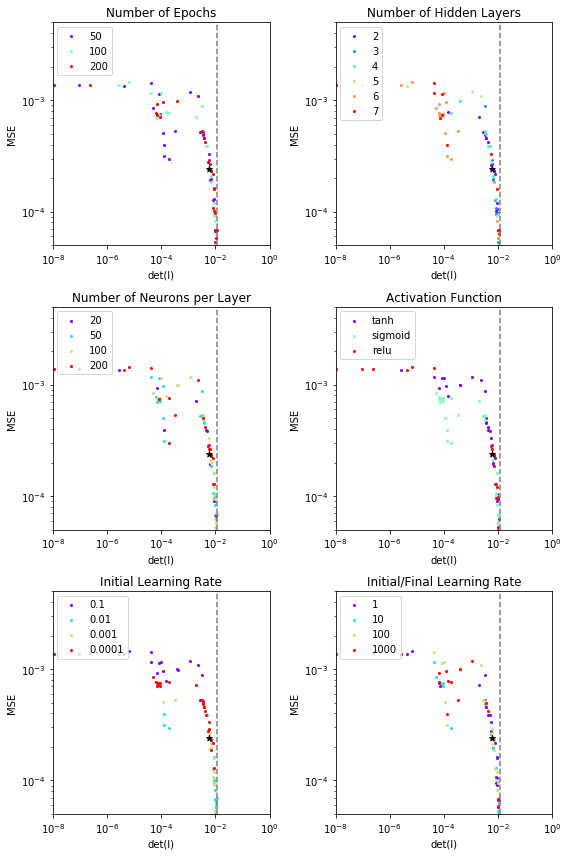

In [26]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000./nsamples)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)
idx=7 # Det(I) truth test
idy=8 # MSE truth test

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[5*10**(-5),.005]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
f.set_size_inches(8,12)

# choices_nepochs
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_epochs)))
for i in range(len(choices_epochs)):
    thisdata=sublist(data,1,i)
    if len(thisdata)!=0:
        ax1.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_epochs[i]))
ax1.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Number of Epochs')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    if len(thisdata)!=0:
        ax2.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    if len(thisdata)!=0:
        ax3.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    if len(thisdata)!=0:
        ax4.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,5,i)
    if len(thisdata)!=0:
        ax5.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax5.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Initial Learning Rate')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,6,i)
    if len(thisdata)!=0:
        ax6.scatter(thisdata[:,idx], thisdata[:,idy],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax6.scatter(data[0,idx], data[0,idy],color='black',marker="*")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial/Final Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

#######
#Plot
plt.tight_layout()
plt.show()

### T3d) Compare test and train samples

Let us also, as cross check, compare the MSE and Fisher Information of the test amnd train samples

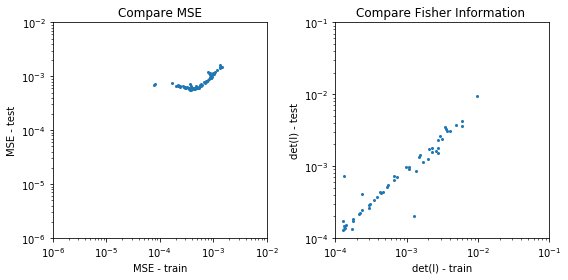

In [28]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000./nsamples)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

add=0 #parton
add=4 #detector

#######
#Figure
myrangefi=[10**(-4),10**(-1)]
myrangemse=[10**(-6),10**(-2)]
mysize=4
f, (ax1,ax2) = plt.subplots(1,2)
f.set_size_inches(8,4)

# MSE
ax1.scatter(data[:,10+add], data[:,8+add],s=mysize,alpha=1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('MSE - train')
ax1.set_ylabel('MSE - test')
ax1.set_xlim(myrangemse)
ax1.set_ylim(myrangemse)
ax1.set_title('Compare MSE')

# Fisher
ax2.scatter(data[:,9+add], data[:,7+add],s=mysize,alpha=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I) - train')
ax2.set_ylabel('det(I) - test')
ax2.set_xlim(myrangefi)
ax2.set_ylim(myrangefi)
ax2.set_title('Compare Fisher Information ')

#######
#Plot
plt.tight_layout()
plt.show()

### T3e) Compare Truth and Detector Samples

Let us also, as cross check, compare the MSE and Fisher Info for the Truth and Detector level samples 

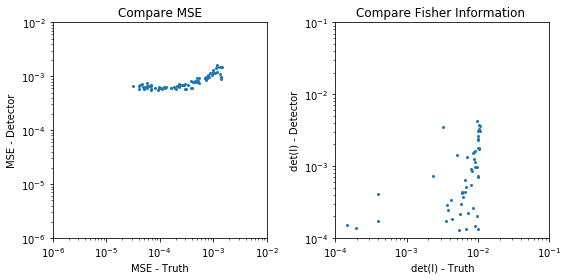

In [32]:
#######
#Input Data
data = np.load(usesummaryfile)

add=0 #test
#add=2 #train

#######
#Figure
myrangefi=[10**(-4),10**(-1)]
myrangemse=[10**(-6),10**(-2)]
mysize=4
f, (ax1,ax2) = plt.subplots(1,2)
f.set_size_inches(8,4)

# MSE
ax1.scatter(data[:,8+add], data[:,12+add],s=mysize,alpha=1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('MSE - Truth')
ax1.set_ylabel('MSE - Detector')
ax1.set_xlim(myrangemse)
ax1.set_ylim(myrangemse)
ax1.set_title('Compare MSE')

# Fisher
ax2.scatter(data[:,7+add], data[:,11+add],s=mysize,alpha=1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I) - Truth')
ax2.set_ylabel('det(I) - Detector')
ax2.set_xlim(myrangefi)
ax2.set_ylim(myrangefi)
ax2.set_title('Compare Fisher Information ')

#######
#Plot
plt.tight_layout()
plt.show()

### T3f) Get list of good settings

Let us now output the best settings

In [38]:
#Sorted by
idsort=8 # test Parton
idsort=12 # test Detector

#Input Data
data = np.load(usesummaryfile)
data_sort = data[data[:,idsort].argsort()[::1]][:5,:]

for i in range(len(data_sort)):
    print ('Setting with det(I)=',data_sort[i,7],'and MSE=',data_sort[i,8], 'had settings')
    print (' - Number of Epochs:',choices_epochs[int(data_sort[i,1])])
    print (' - Number of Hidden Layers:',choices_nhidden[int(data_sort[i,2])])
    print (' - Number of Neurons per Layer:',choices_nneuron[int(data_sort[i,3])])
    print (' - Activation Function:',choices_activation[int(data_sort[i,4])])
    print (' - Initial Learning Rate:',choices_lrinitial[int(data_sort[i,5])])
    print (' - Final Learning Rate:',choices_lrinitial[int(data_sort[i,6])]/choices_lrratio[int(data_sort[i,5])])
    print ('')

Setting with det(I)= 0.01053526120426315 and MSE= 6.690339237172866e-05 had settings
 - Number of Epochs: 200
 - Number of Hidden Layers: 6
 - Number of Neurons per Layer: 200
 - Activation Function: sigmoid
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.01

Setting with det(I)= 0.009761464785988603 and MSE= 4.692120268024988e-05 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 200
 - Activation Function: relu
 - Initial Learning Rate: 0.001
 - Final Learning Rate: 0.0001

Setting with det(I)= 0.01021369631599553 and MSE= 5.844616955667731e-05 had settings
 - Number of Epochs: 200
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 100
 - Activation Function: sigmoid
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.01

Setting with det(I)= 0.010734977213513923 and MSE= 6.249467139829947e-05 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 7
 - Number of Neurons per Layer: 50
 - Activation Fu